# notebook to test scat transform

In [1]:
import tensorflow as tf
import os, sys, time, subprocess, h5py, argparse, logging
import numpy as np
from os.path import join as oj
sys.path.append('scat_tf')
from scat_tf import scattering
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (6, 6)

# make scat

In [2]:
# requires NCHW format (cuDNN default - tf is NHWC)
M, N = 32, 32
J = 2 # spatial scale of filter
scat = scattering.Scattering(M=M, N=N, J=J)

# make scat_comp
placeholder = tf.placeholder(tf.float32, (1, 3, 32, 32))
scat_comp = scat(placeholder)
print("M", M, "N", N, "J", J, 'input', placeholder.shape, 'output', scat_comp.shape)

M 32 N 32 J 2 input (1, 3, 32, 32) output (1, 243, 8, 8)


# max activation

In [ ]:
# initialize
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [22]:
filter_num = 6
t_score = tf.reduce_mean(scat_comp[0, filter_num, :, :]) # defining the optimization objective
t_grad = tf.gradients(t_score, placeholder)[0] # behold the power of automatic differentiation!

In [41]:
im_noise = np.random.uniform(size=(32, 32, 3))
im_tf = np.expand_dims(np.transpose(im_noise, (2, 0, 1)), 0)

step = 0.1
num_iters = 50
with tf.device("/gpu:0"):
    for i in tqdm(range(num_iters)):
        g, score = sess.run([t_grad, t_score], {placeholder: im_tf})
        g /= g.std() + 1e-8 # normalizing the gradient, so the same step size should work for different things        
        im_tf += g * step
        
        #if i == 100: # normalize to keep things from blowing up
        #    im_tf /= im_tf.std()
        
#         print(score, end = ' ')
#         im_out = np.transpose(np.array(im_tf)[0], (1, 2, 0))
#         plt.imshow(im_out)
#         plt.show()

100%|██████████| 50/50 [00:11<00:00,  4.39it/s]


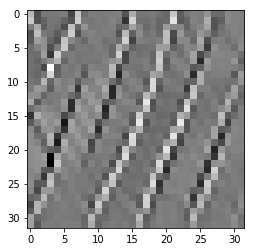

In [42]:
def visstd(a, s=0.1): # normalize the image range for visualization
    return (a-a.mean())/max(a.std(), 1e-4)*s + 0.5

# visualize max activation
im_out = np.transpose(np.array(im_tf)[0], (1, 2, 0))[:, :, 0]
plt.imshow(visstd(im_out), interpolation="None", cmap='gray')
plt.show()

In [44]:
print(im_out.flatten()[:5], np.max(im_out), np.min(im_out))

[-4.22199014e+02  4.43243568e-01  5.77648208e-01 -7.38533189e+02
  2.57731218e-01] 0.9998816070444386 -1291.8403209213984


# visualize outputs (todo: visualize filters)

('features_new.shape', (2, 8, 8, 243))


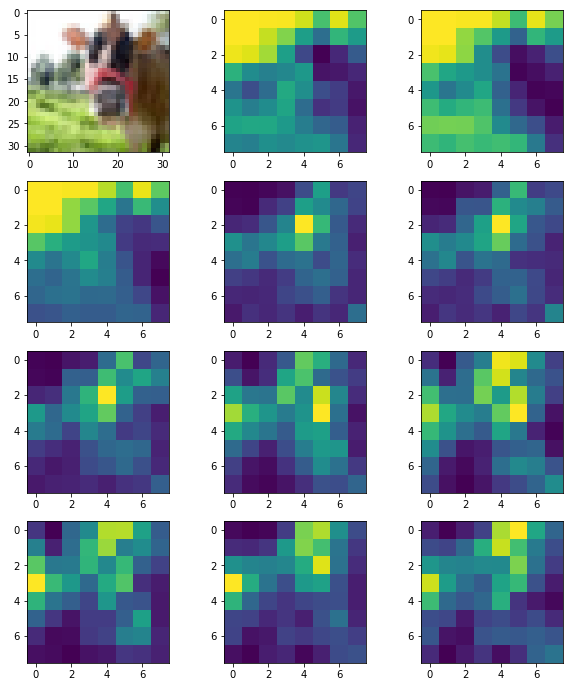

In [3]:
features_summed = np.sum(features_new, axis=3)
# features_summed2 = np.sum(features_new2, axis=3)
print('features_new.shape', features_new.shape)
ROWS = 4
N = 3
plt.subplot(ROWS,N,1)
plt.imshow(ims_orig[0])
plt.grid(False)

for j in range(ROWS*N - 1):
    plt.subplot(ROWS, N, j+2)
    plt.imshow(features_new[0, :, :, j])
# plt.subplot(ROWS,N,3)
# plt.imshow(features_new[0, :, :, 1])
plt.show()

# filter analysis (not working)

In [62]:
print("M", M, "N", N, "J", J)
s = scattering.Scattering(M, N, J)
psi = scat.Psi
phi = scat.Phi

M 16 N 16 J 1


AttributeError: 'Tensor' object has no attribute 'Psi'